In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid

import matplotlib.pyplot as plt

In [3]:
import xwmt

### Load grids and data

In [186]:
gridname = 'rho2' # choose from ['zstr', 'natv', 'rho2']
dt = 'monthly' # choose from ['monthly', 'daily', 'hourly']

# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"
#time = "1900_02_01"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

# Select year-long subset
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming to match hdrake conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', 'salt':'so'})
ds['sigma2'] = ds['rhopot2']-1000.

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    "lon": xr.DataArray(ocean_grid["geolon"].values, dims=('yh', 'xh',)),
    "lat": xr.DataArray(ocean_grid["geolat"].values, dims=('yh', 'xh',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'}
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

In [187]:
import yaml

with open("../../xwmt/conventions/MOM6.yaml", "r") as stream:
    try:
        budgets_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
budgets_dict

{'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'tendency': 'opotemptend'},
  'rhs': {'horizontal_advection': 'T_advection_xy',
   'vertical_advection': 'Th_tendency_vert_remap',
   'boundary_forcing': 'boundary_forcing_heat_tendency',
   'vertical_diffusion': 'opottempdiff',
   'neutral_diffusion': 'opottemppmdiff',
   'frazil_ice': 'frazil_heat_tendency',
   'geothermal': 'internal_heat_heat_tendency'},
  'surface_flux': {'total': 'hfds',
   'latent': 'hflso',
   'sensible': 'hfsso',
   'longwave': 'rlntds',
   'shortwave': 'rsntds',
   'frazil_ice': 'hfsifrazil',
   'mass_transfer': 'heat_content_surfwater',
   'basal': None}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'tendency': 'osalttend'},
  'rhs': {'horizontal_advection': 'S_advection_xy',
   'vertical_advection': 'Sh_tendency_vert_remap',
   'boundary_forcing': 'boundary_forcing_salt_tendency',
   'vertical_diffusion': 'osaltdiff',
   'neutral_diffusion': 'osaltpmdiff',
   'frazil_ice':

In [195]:
wmt = xwmt.WaterMassTransformations(grid, budgets_dict)

In [196]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    kwargs = {"sum_components":True, "group_processes":True}
    G_temperature = wmt.integrate_transformations(
        "temperature",
        bins=np.arange(-2, 30, 0.25),
        **kwargs
    ).mean('time').compute()
    G_salinity = wmt.integrate_transformations(
        "salinity",
        bins=np.arange(0, 50, 0.25),
        **kwargs
    ).mean('time').compute()
    G_density = wmt.integrate_transformations(
        "sigma2",
        bins=np.arange(10, 40, 0.25),
        **kwargs
    ).mean('time').compute()

Closed water mass transformation budgets in temperature, salinity, and density space.

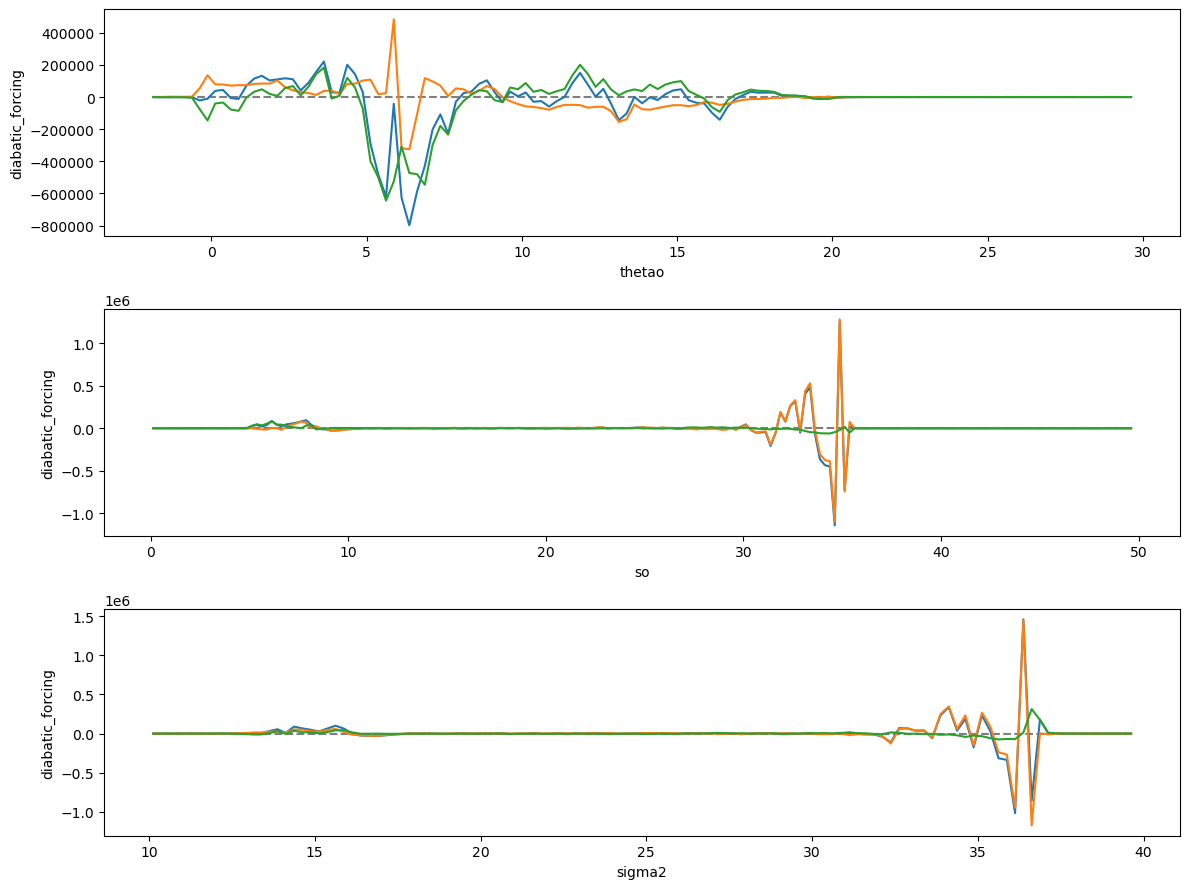

In [197]:
fig, axes = plt.subplots(3,1,figsize=(12, 9))
for G, ax in zip([G_temperature, G_salinity, G_density], axes):
    (G['total_tendency'] - (G['advection'] + G['diabatic_forcing'])).plot(ax=ax, ls="--", color="k", alpha=0.5)
    G['total_tendency'].plot(ax=ax)
    G['advection'].plot(ax=ax)
    G['diabatic_forcing'].plot(ax=ax)
plt.tight_layout()

Comparison of watermass transformations in salinity space, directly due to surface salt flux and indirectly due to dilution by surface freshwater mass flux.

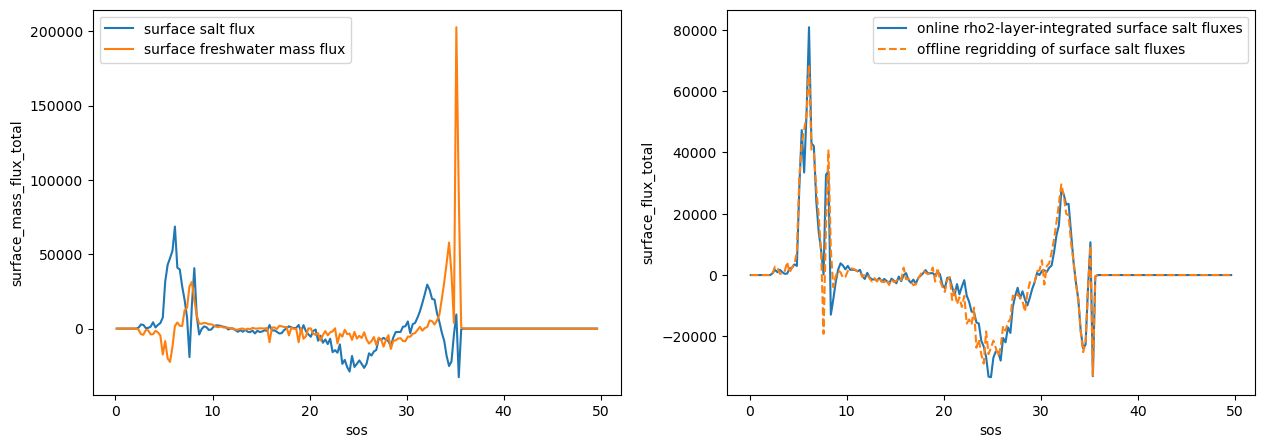

In [198]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
G_salinity['surface_flux_basal'].plot(label="surface salt flux")
G_salinity['surface_mass_flux_total'].plot(label="surface freshwater mass flux")
plt.legend()
plt.subplot(1,2,2)
G_salinity['boundary_forcing'].plot(label="online rho2-layer-integrated surface salt fluxes")
G_salinity['surface_flux_total'].plot(ls="--", label="offline regridding of surface salt fluxes")
plt.legend();

Decomposition of surface (freshwater) mass fluxes

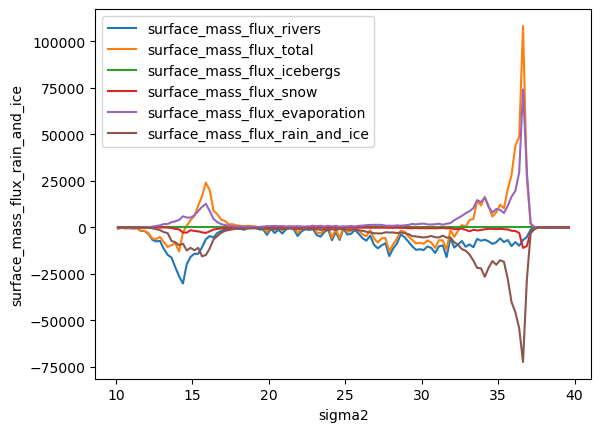

In [200]:
for v in wmt.available_processes():
    if ("surface_mass_flux" in v):
        G_density[v].plot(label=v)
plt.legend()